In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import pylab as pl
from matplotlib.pyplot import figure
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, to_hex
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
from yellowbrick.cluster import KElbowVisualizer
sns.set()
%matplotlib inline

In [2]:
ds = pd.read_csv('Cust_Segmentation.csv', header = 0)

In [3]:
ds.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2


In [4]:
ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Customer Id,850.0,425.500000,245.518160,1.000,213.25000,425.500,637.75000,850.000
Age,850.0,35.029412,8.041432,20.000,29.00000,34.000,41.00000,56.000
Edu,850.0,1.710588,0.927784,1.000,1.00000,1.000,2.00000,5.000
Years Employed,850.0,8.565882,6.777884,0.000,3.00000,7.000,13.00000,33.000
Income,850.0,46.675294,38.543054,13.000,24.00000,35.000,55.75000,446.000
Card Debt,850.0,1.576820,2.125843,0.012,0.38250,0.885,1.89850,20.561
Other Debt,850.0,3.078773,3.398799,0.046,1.04575,2.003,3.90325,35.197
Defaulted,700.0,0.261429,0.439727,0.000,0.00000,0.000,1.00000,1.000
DebtIncomeRatio,850.0,10.171647,6.719441,0.100,5.10000,8.700,13.80000,41.300


In [5]:
print(ds.info())
print("*" * 120)
print(ds.isnull().sum())
print("*" * 120)
print("Length of the Dataset is " ,len(ds))
print("*" * 120)
print(ds.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
Customer Id        850 non-null int64
Age                850 non-null int64
Edu                850 non-null int64
Years Employed     850 non-null int64
Income             850 non-null int64
Card Debt          850 non-null float64
Other Debt         850 non-null float64
Defaulted          700 non-null float64
Address            850 non-null object
DebtIncomeRatio    850 non-null float64
dtypes: float64(4), int64(5), object(1)
memory usage: 66.5+ KB
None
************************************************************************************************************************
Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
Address              0
DebtIncomeRatio      0
dtype: int64
**************************************************************************

<h2 id="pre_processing">Pre-processing</h2

As you can see, __Address__ in this dataset is a categorical variable. k-means algorithm isn't directly applicable to categorical variables because Euclidean distance function isn't really meaningful for discrete variables. So, lets drop this feature and run clustering.

In [6]:
df = ds.drop('Address' , axis=1)

In [7]:
df.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [8]:
Age=ds['Age']

Text(0.5, 1.0, 'Age Distribution')

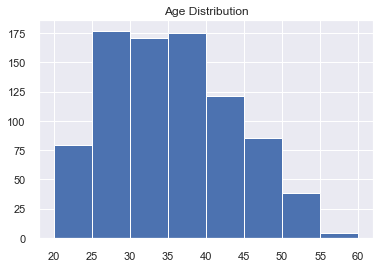

In [9]:
plt.hist(ds['Age'], bins = [20,25,30,35,40,45,50,55,60])
plt.title('Age Distribution')

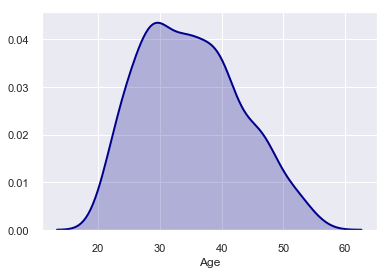

In [10]:
sns.distplot(ds['Age'], hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True, 'linewidth': 2})

In [11]:
Ratio=ds['DebtIncomeRatio']

Text(0.5, 1.0, 'Debt-Income Ratio Distribution')

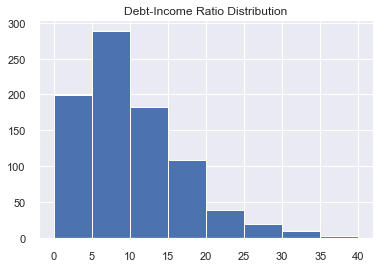

In [12]:
plt.hist(Ratio, bins = [0,5,10,15,20,25,30,35,40])
plt.title('Debt-Income Ratio Distribution')

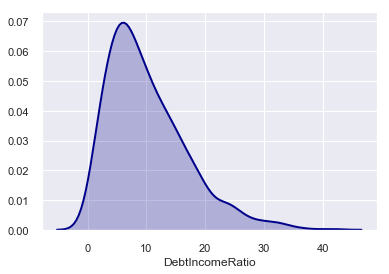

In [13]:
sns.distplot(Ratio, hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True, 'linewidth': 2})

In [14]:
total_d=ds['Card Debt']+ds['Other Debt']

In [15]:
df["Total Debt"] = total_d

In [16]:
Income=ds['Income']

Text(0.5, 1.0, 'Income Distibution')

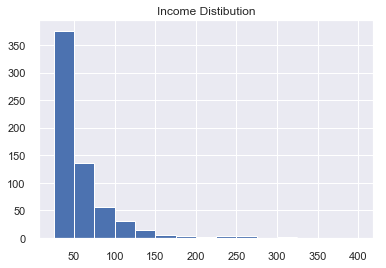

In [17]:
plt.hist(Income, bins = [25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400])
plt.title('Income Distibution')

In [18]:
Employ=ds['Years Employed']

Text(0.5, 1.0, 'Distribution Of years Employed')

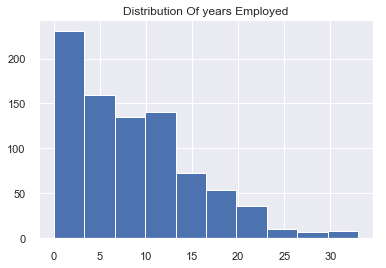

In [19]:
plt.hist(Employ)
plt.title('Distribution Of years Employed')

# Elbow Method

In [20]:
X = df.iloc[:, [4,8]].values

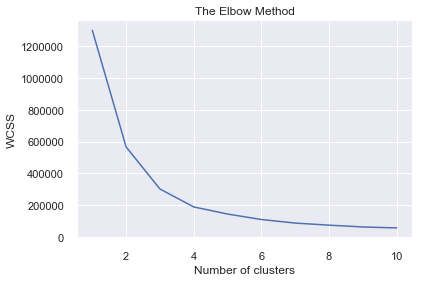

In [21]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### Normalizing over the standard deviation
Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use __StandardScaler()__ to normalize our dataset

In [22]:
X = df.values[:,1:]
X = np.nan_to_num(X)
clus_dataset = StandardScaler().fit_transform(X)
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 1 0 0 2 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0
 0 0 1 0 1 0 2 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0
 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 1 0 0 1 0 1 0 0 1 2 0 1 0 0 0 0 0 0 2 1 0 0 0 0 1 0 0 1 1 0 1 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 2 0 0 0 1 0 1 1 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 2
 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 1 0 2 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 1 0 

In [23]:
df["Clus_km"] = labels
df.head(5)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total Debt,Clus_km
0,1,41,2,6,19,0.124,1.073,0.0,6.3,1.197,0
1,2,47,1,26,100,4.582,8.218,0.0,12.8,12.800,1
2,3,33,2,10,57,6.111,5.802,1.0,20.9,11.913,0
3,4,29,2,4,19,0.681,0.516,0.0,6.3,1.197,0
4,5,47,1,31,253,9.308,8.908,0.0,7.2,18.216,2


In [24]:
clus = df['Clus_km']

Text(0, 0.5, 'Number of Customer')

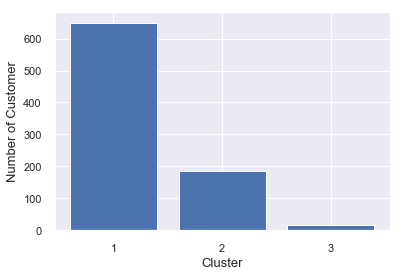

In [25]:
plt.bar(height = clus.value_counts(),x = ['1','2','3'])
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('Number of Customer', fontsize=13)

In [26]:
df.groupby('Clus_km').mean()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total Debt
Clus_km,,,,,,,,,,
0,432.006154,32.967692,1.613846,6.389231,31.204615,1.032711,2.108345,0.284658,10.095385,3.141055
1,402.853261,41.413043,1.967391,15.288043,84.880435,3.104440,5.764261,0.170068,10.660326,8.868701
2,421.625000,45.375000,2.687500,19.687500,235.812500,6.113625,11.619313,0.333333,7.650000,17.732938


In [27]:
X=df.iloc[:, [4,8]].values

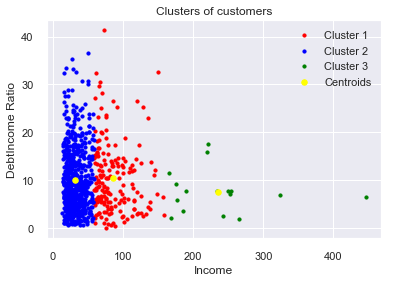

In [28]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 10, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 10, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 30, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')

plt.legend()
plt.show()

# Silhouette Method

In [29]:
X= ds['Income']
Y= ds['DebtIncomeRatio']
Z= np.vstack((X,Y)).T
Z=pd.DataFrame(Z)

In [30]:
X=df.iloc[:, [4,8]].values
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.7249334331557766
For n_clusters=3, The Silhouette Coefficient is 0.6246563472359685
For n_clusters=4, The Silhouette Coefficient is 0.5595018085618844
For n_clusters=5, The Silhouette Coefficient is 0.46675207105358646
For n_clusters=6, The Silhouette Coefficient is 0.46690017649892745
For n_clusters=7, The Silhouette Coefficient is 0.45288076371551866
For n_clusters=8, The Silhouette Coefficient is 0.3977874906174386
For n_clusters=9, The Silhouette Coefficient is 0.39431385935870733
For n_clusters=10, The Silhouette Coefficient is 0.36587622060855324


In [31]:
silh=[[1,0]]
for x in range(2,11):
    KMean= KMeans(n_clusters=x)
    KMean.fit(Z)
    label=KMean.predict(Z)
    n=silhouette_score(Z, label)
    silh.append([x, n])

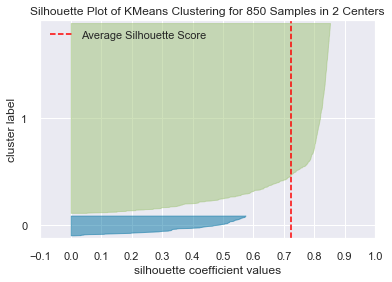

Silhouette Score( n = 2 ): {0.7249334331557766}


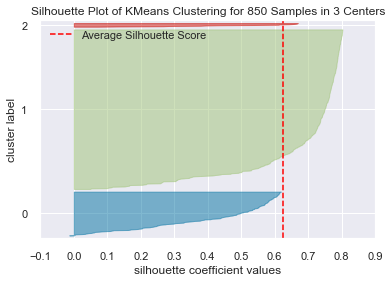

Silhouette Score( n = 3 ): {0.6216510202130815}


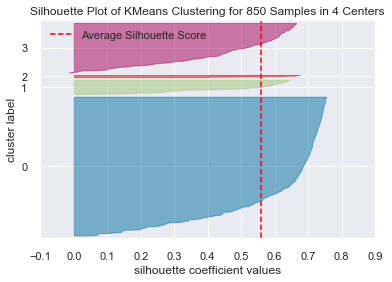

Silhouette Score( n = 4 ): {0.5595018085618844}


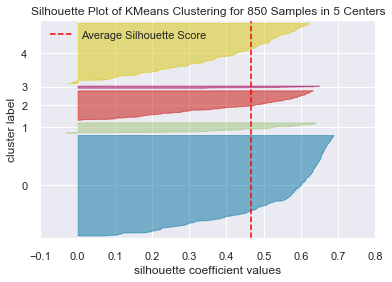

Silhouette Score( n = 5 ): {0.46675207105358646}


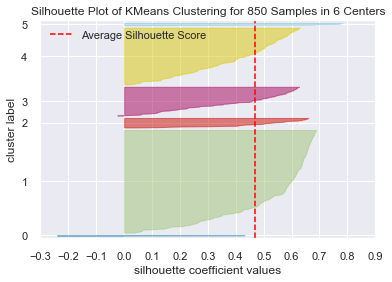

Silhouette Score( n = 6 ): {0.45923842595366815}


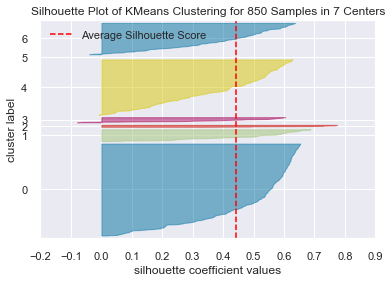

Silhouette Score( n = 7 ): {0.45289710970481567}


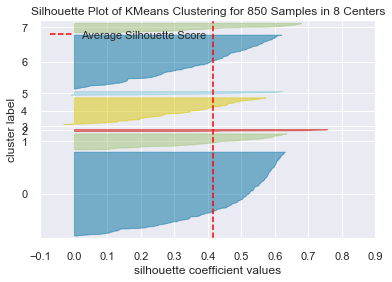

Silhouette Score( n = 8 ): {0.4162730186706968}


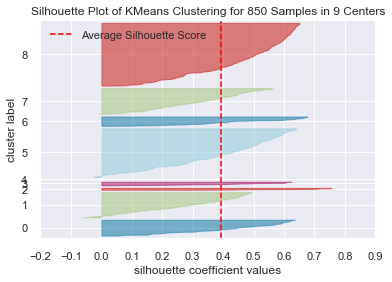

Silhouette Score( n = 9 ): {0.39474008589280185}


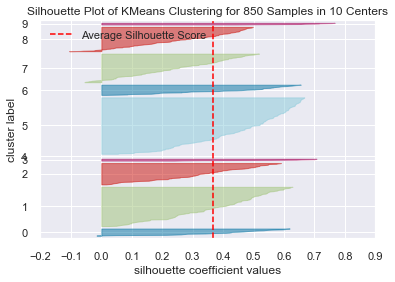

Silhouette Score( n = 10 ): {0.3865823685526707}


In [32]:
for n in range(2,11):
    model = KMeans(n, random_state=42)      #printing graph
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(Z)
    visualizer.show()
    KMean= KMeans(n_clusters=n)             #printing values
    KMean.fit(Z)
    label=KMean.predict(Z)
    print(f'Silhouette Score( n =',n,'):', {silhouette_score(Z, label)})

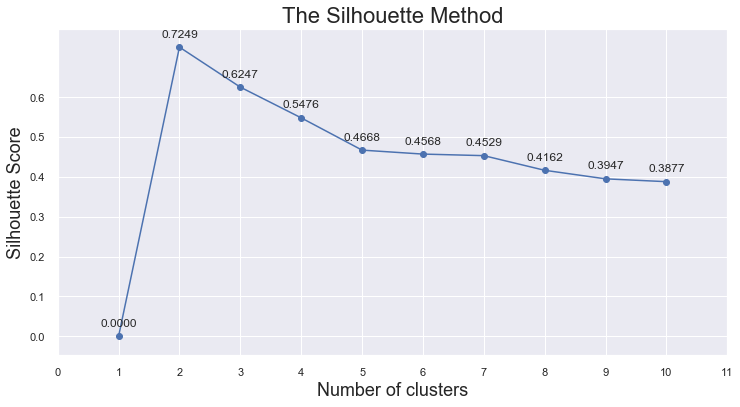

In [33]:
data = np.array(silh)
x, y = data.T
figure(figsize=(12, 6))
plt.scatter(x,y)
plt.plot(x,y)
plt.title('The Silhouette Method', fontsize=22)
plt.xlabel('Number of clusters', fontsize=18)
plt.ylabel('Silhouette Score', fontsize=18)
for x,y in zip(x,y):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize=12) # horizontal alignment can be left, right or center
plt.xticks(np.arange(0,12,1))
plt.yticks(np.arange(0,0.7,0.1))
plt.show()

# Dendrogram Method

In [34]:
X = df.values[:,1:]
X = np.nan_to_num(X)
clus_dataset = StandardScaler().fit_transform(X)
clusterNum = 2
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 

In [35]:
df["silh"] = labels
df.head(5)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total Debt,Clus_km,silh
0,1,41,2,6,19,0.124,1.073,0.0,6.3,1.197,0,0
1,2,47,1,26,100,4.582,8.218,0.0,12.8,12.800,1,1
2,3,33,2,10,57,6.111,5.802,1.0,20.9,11.913,0,0
3,4,29,2,4,19,0.681,0.516,0.0,6.3,1.197,0,0
4,5,47,1,31,253,9.308,8.908,0.0,7.2,18.216,2,1


In [36]:
silh=df["silh"]

Text(0, 0.5, 'Number of Customer')

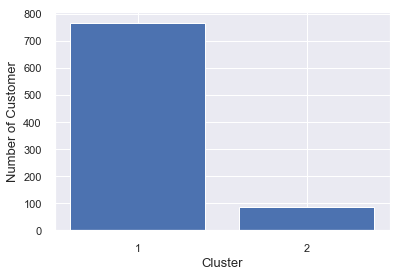

In [37]:
plt.bar(height = silh.value_counts(),x = ['1','2'])
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('Number of Customer', fontsize=13)

In [38]:
X=df.iloc[:, [4,8]].values

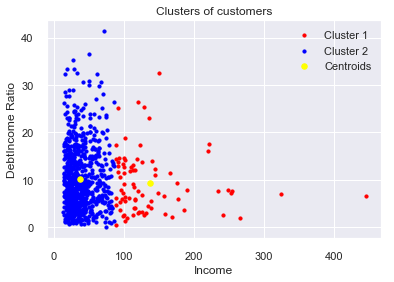

In [39]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 10, c = 'blue', label = 'Cluster 2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 30, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Income')
plt.ylabel('DebtIncome Ratio')
plt.legend()
plt.show()

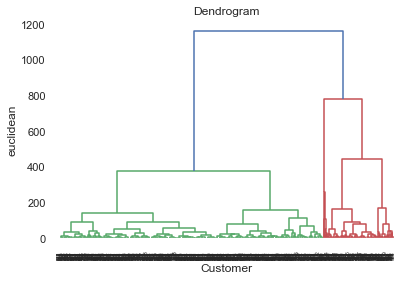

In [40]:
dend=sch.dendrogram(sch.linkage(X, method='ward'))
plt.title("Dendrogram")
plt.xlabel('Customer')
plt.ylabel('euclidean')
plt.show()

In [41]:
hc=AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward' )
y_hc = hc.fit_predict(X)
print(y_hc)

[1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1
 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1
 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0
 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1
 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 0 1 

Text(0, 0.5, 'Number of Customer')

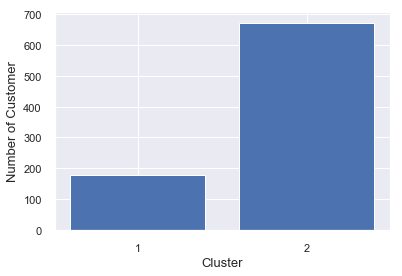

In [42]:
plt.bar(height = np.bincount(y_hc),x = ['1','2'])
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('Number of Customer', fontsize=13)

In [43]:
df['y_hc']=y_hc

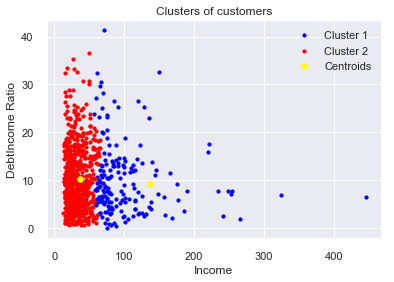

In [44]:
# Visualising the clusters
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 10, c = 'blue', label = 'Cluster 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 10, c = 'red', label = 'Cluster 2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 30, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Income')
plt.ylabel('DebtIncome Ratio')
plt.legend()
plt.show()

# Calinski Harabasz Method

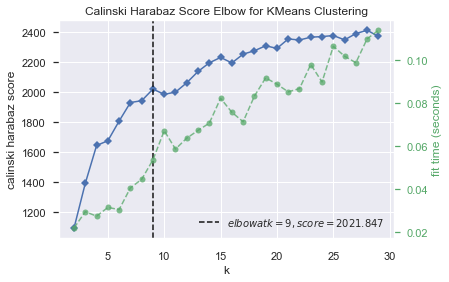

In [47]:
# Calinski Harabasz Score for K means
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
z=visualizer.fit_predict(X)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [48]:
df['CH-score']=z
ch=df['CH-score']

In [49]:
ch.value_counts()

0    368
1    229
7    116
5     69
3     41
2     17
4      9
6      1
Name: CH-score, dtype: int64

Text(0, 0.5, 'Number of Customer')

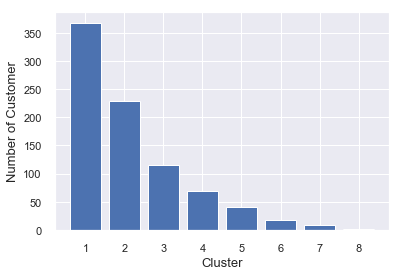

In [50]:
plt.bar(height = ch.value_counts(),x = ['1','2','3','4','5','6','7','8'])
plt.xlabel('Cluster', fontsize=13)
plt.ylabel('Number of Customer', fontsize=13)

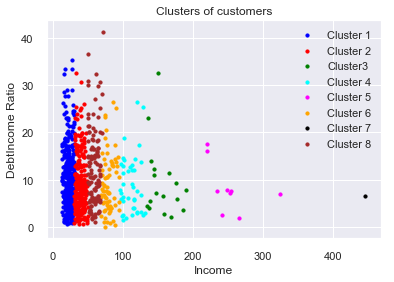

In [51]:
#kmeans = KMeans(n_clusters = 8, init = 'k-means++', random_state = 42)
plt.scatter(X[ch == 0, 0], X[ch == 0, 1], s = 10, c = 'blue', label = 'Cluster 1')
plt.scatter(X[ch == 1, 0], X[ch == 1, 1], s = 10, c = 'red', label = 'Cluster 2')
plt.scatter(X[ch == 2, 0], X[ch == 2, 1], s = 10, c='green', label = 'Cluster3')
plt.scatter(X[ch == 3, 0], X[ch == 3, 1], s = 10, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[ch == 4, 0], X[ch == 4, 1], s = 10, c = 'magenta', label = 'Cluster 5')
plt.scatter(X[ch == 5, 0], X[ch == 5, 1], s = 10, c = 'orange', label = 'Cluster 6')
plt.scatter(X[ch == 6, 0], X[ch == 6, 1], s = 10, c = 'black', label = 'Cluster 7')
plt.scatter(X[ch == 7, 0], X[ch == 7, 1], s = 10, c = 'brown', label = 'Cluster 8')
plt.title('Clusters of customers')
plt.xlabel('Income')
plt.ylabel('DebtIncome Ratio')
plt.legend()
plt.show()